### Telecom Churn Prediction

#Importing libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix
from xgboost import XGBClassifier
from warnings import filterwarnings

pd.set_option("display.max_rows", 300)
pd.set_option("display.max_columns", 300)
filterwarnings('ignore')

In [2]:
plt.rcParams["figure.autolayout"] = True

In [3]:
## Global Variables
seed = 42
hvc_threshold = 70.0 # High value Customers
miss_threshold = 40.0 # Threshold to remove the columns that have this % missing values.
corr_threshold = 0.7
pca_comp = 50 # PCA components
test_set_size = 0.2 # Size of test set when doing a train-test-split

#The following custom functions are created after iterative experimentations, so as to make the code much more modular

In [4]:
master = pd.read_csv("train.csv")
master.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.0,0.0,0.00,0.0,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.0,0.00,0.0,0.0,0.0,0.0,0.0,65.09,204.99,1.01,0.0,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,3.26,24.76,24.71,0.00,7.61,0.21,7.46,19.96,14.96,0.0,0.0,0.0,0.0,0.0,0.0,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.0,0.0,0.0,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,6/22/2014,7/10/2014,8/24/2014,65,65,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.00,0.00,0.0,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,1.68,19.09,10.53,1.41,18.68,11.09,0.35,1.66,3.40,3.44,39.44,25.03,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,6/12/2014,7/10/2014,8/26/2014,0,0,0,NaN,7/8/2014,NaN,NaN,1.0,NaN,NaN,145.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN,Na

In [5]:
def create_total_data_recharge_columns(temp):
    """
    New columns related to recharge values are created.
    """
    temp['total_data_rech_amt_6'] = temp['av_rech_amt_data_6'] * temp['total_rech_data_6']
    temp['total_data_rech_amt_7'] = temp['av_rech_amt_data_7'] * temp['total_rech_data_7']
    temp['total_data_rech_amt_8'] = temp['av_rech_amt_data_8'] * temp['total_rech_data_8']

    # Drop the columns already accounted for 
    drop_cols = ['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8','av_rech_amt_data_6', 'av_rech_amt_data_7']
    temp = temp.drop(drop_cols, axis=1)

    temp['total_rech_amt_6'] = temp['total_rech_amt_6'].fillna(0)
    temp['total_rech_amt_7'] = temp['total_rech_amt_7'].fillna(0)
    temp['total_data_rech_amt_6'] = temp['total_data_rech_amt_6'].fillna(0)
    temp['total_data_rech_amt_7'] = temp['total_data_rech_amt_7'].fillna(0)
    return temp

def filter_hvc(temp):
    """
    This function is used to remove the High Value customers from the dataset.
    """    
    good_phase_average_rech_amt = (temp['total_rech_amt_6'].fillna(0) + temp['total_rech_amt_7'].fillna(0) + temp['total_data_rech_amt_6'].fillna(0) + temp['total_data_rech_amt_7'].fillna(0) ) / 2
    gd_phase_avg_rech_amt_70 = np.percentile(good_phase_average_rech_amt, hvc_threshold)
    
    temp  = temp[good_phase_average_rech_amt > gd_phase_avg_rech_amt_70]
    return temp

def missing_values(temp):
    """
    Drop the columns with more percentage of null values than the threshold.
    """
    miss_vals = round(temp.isna().sum() / len(temp) * 100, 2).sort_values(ascending=False)
    
    drop_miss_cols = miss_vals[miss_vals > miss_threshold].index.tolist()
    temp = temp.drop(drop_miss_cols,axis=1)
    
    return temp

def redundant_columns(temp):
    """
    This function is used to drop redundant columns 
    """
    ## Dropping date columns:
    date_cols = [col for col in list(temp.columns) if 'date' in col]
    temp.drop(date_cols,axis=1,inplace=True)

    ## Dropping Id and Circle_id columns as they are redundant for training the model:
    temp.drop(["id","circle_id"],axis=1,inplace=True)

    ## Checking columns with only one unique value. Since there is no variance, these columns do not add any  value to model.
    drop_singles = []

    for col in temp.columns:
        if temp[f'{col}'].nunique() == 1:
            drop_singles.append(col)
            
    temp = temp.drop(drop_singles,axis=1)
    return temp


def drop_correlated_features(temp):
    """
    The following columns were found out to be highly correlated thus removing these particular columns via hardcoding it.
    """
    drop_col_corr = ['loc_og_t2m_mou_6', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 
                    'std_og_t2m_mou_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 
                    'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'std_ic_t2m_mou_6', 'std_ic_t2m_mou_7', 
                    'std_ic_t2m_mou_8', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8', 'total_rech_amt_6', 'total_rech_amt_7', 
                    'total_rech_amt_8', 'vol_3g_mb_6', 'vol_3g_mb_7', 'vol_3g_mb_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
                    'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
                    'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8']

    # Drop the high corr columns
    temp.drop(drop_col_corr, axis=1, inplace=True)
    temp.shape
    
    return temp

def create_mou(temp):
    temp['total_mou_6'] = temp['onnet_mou_6'] + temp['offnet_mou_6']
    temp['total_mou_7'] = temp['onnet_mou_7'] + temp['offnet_mou_7']
    temp['total_mou_8'] = temp['onnet_mou_8'] + temp['offnet_mou_8']

    # Drop the redundant columns
    temp.drop(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8'], axis=1, inplace=True)
    
    return temp


def create_good_phase_cols(temp):
    col_for_6_7 = [col[:-2] for col in temp.columns if '6' in col or '7' in col]
    
    for col in set(col_for_6_7):
        temp[f'gd_ph_{col}'] = ( temp[f'{col}_6'] + temp[f'{col}_7'] ) / 2
        temp.drop([f'{col}_6', f'{col}_7'], axis=1, inplace=True)

    return temp 

def vbc_cols(temp):
    temp['gd_ph_vbc_3g'] = ( temp['jul_vbc_3g'] + temp['jun_vbc_3g'] ) / 2

    # Drop redundant column
    temp.drop(['jul_vbc_3g', 'jun_vbc_3g'], axis=1, inplace=True)

    # Rename the august column for vbc to vbc_3g_8
    temp['vbc_3g_8'] = temp['aug_vbc_3g']
    temp.drop('aug_vbc_3g', axis=1, inplace=True)
    
    return temp

def cap_outlier(temp):    
    """
    This function is used to cap the outliers from some of the columns in the dataset. 
    """
    ## Capping the outliers to certain values:
    col_upr_lmt = [('arpu_8', 7000), ('loc_og_mou_8', 4000), ('max_rech_amt_8', 1000 ), ('last_day_rch_amt_8', 1000 ), 
            ('aon', 3000), ('total_mou_8', 4000)]
    
    for col, value in col_upr_lmt:
        temp[col] = temp[col].apply(lambda x : x if x < value else value)

    return temp 

def impute_numeric(temp):    
    """
    This function is used to efficiently impute the missing values from numeric columns.
    """
    numeric_cols = temp.select_dtypes(["float64","int64"]).columns.tolist()
    imputer = SimpleImputer(missing_values= np.NaN, strategy='constant',fill_value=0)
    imputer = imputer.fit(temp[numeric_cols])
    temp[numeric_cols] =  imputer.fit_transform(temp[numeric_cols])
    return temp

#Exploratory Data Analysis

In [6]:
eda = master.copy() ## Create a new object for performing eda.
eda.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.0,0.0,0.00,0.0,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.0,0.00,0.0,0.0,0.0,0.0,0.0,65.09,204.99,1.01,0.0,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,3.26,24.76,24.71,0.00,7.61,0.21,7.46,19.96,14.96,0.0,0.0,0.0,0.0,0.0,0.0,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.0,0.0,0.0,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,6/22/2014,7/10/2014,8/24/2014,65,65,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.00,0.00,0.0,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,1.68,19.09,10.53,1.41,18.68,11.09,0.35,1.66,3.40,3.44,39.44,25.03,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,6/12/2014,7/10/2014,8/26/2014,0,0,0,NaN,7/8/2014,NaN,NaN,1.0,NaN,NaN,145.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN,Na

In [7]:
## Average Revenue per User (ARPU)
arpu = [col for col in list(eda.columns) if 'arpu' in col]
df = eda[arpu]

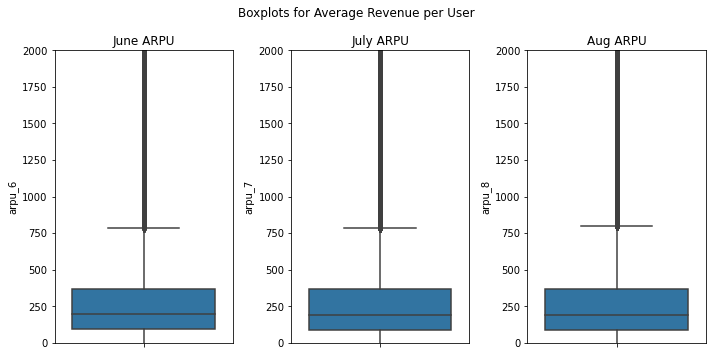

In [8]:
fig, ax = plt.subplots(1,3, figsize=(10,5))
plt.suptitle("Boxplots for Average Revenue per User");

sns.boxplot(y=df.arpu_6,ax=ax[0])
ax[0].set_title("June ARPU")
ax[0].set_ylim([0, 2000])

sns.boxplot(y=df.arpu_7,ax=ax[1])
ax[1].set_title("July ARPU")
ax[1].set_ylim([0, 2000])

sns.boxplot(y=df.arpu_8,ax=ax[2])
ax[2].set_title("Aug ARPU")
ax[2].set_ylim([0, 2000])

plt.show()

Observation - The average revenue per user is roughly the same for the three months

#Average Revenue per User (ARPU) 2G service

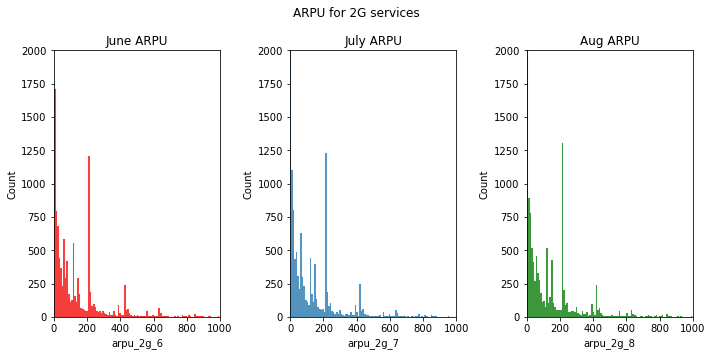

In [9]:
arpu = [col for col in list(eda.columns) if 'arpu' in col]
df = eda[arpu]

fig, ax = plt.subplots(1,3, figsize=(10,5))
plt.suptitle("ARPU for 2G services");

sns.histplot(df["arpu_2g_6"],ax=ax[0],color='r')
ax[0].set_title("June ARPU")
ax[0].set_xlim([0, 1000])
ax[0].set_ylim([0, 2000])

sns.histplot(df["arpu_2g_7"],ax=ax[1])
ax[1].set_title("July ARPU")
ax[1].set_xlim([0, 1000])
ax[1].set_ylim([0, 2000])

sns.histplot(df["arpu_2g_8"],ax=ax[2],color='g')
ax[2].set_title("Aug ARPU")
ax[2].set_xlim([0, 1000])
ax[2].set_ylim([0, 2000])

plt.show()

#Average Revenue per User (ARPU) 3G service

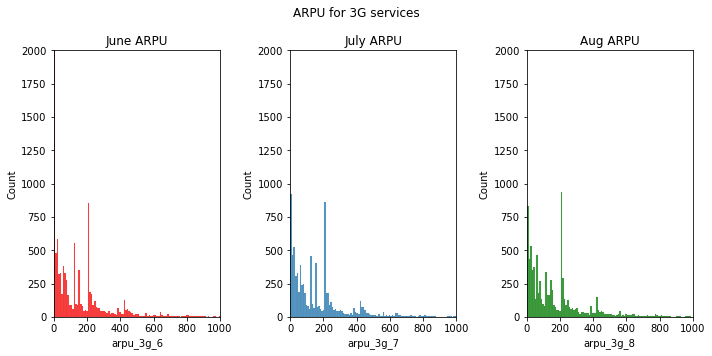

In [10]:
arpu = [col for col in list(eda.columns) if 'arpu' in col]
df = eda[arpu]

fig, ax = plt.subplots(1,3, figsize=(10,5))
plt.suptitle("ARPU for 3G services");

sns.histplot(df["arpu_3g_6"],ax=ax[0],color='r')
ax[0].set_title("June ARPU")
ax[0].set_xlim([0, 1000])
ax[0].set_ylim([0, 2000])

sns.histplot(df["arpu_3g_7"],ax=ax[1])
ax[1].set_title("July ARPU")
ax[1].set_xlim([0, 1000])
ax[1].set_ylim([0, 2000])

sns.histplot(df["arpu_3g_8"],ax=ax[2],color='g')
ax[2].set_title("Aug ARPU")
ax[2].set_xlim([0, 1000])
ax[2].set_ylim([0, 2000])

plt.show()

#Total Recharge Amount for all users

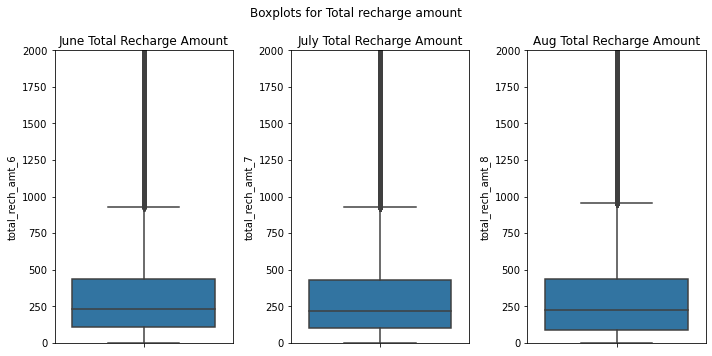

In [11]:
df = eda[["total_rech_amt_6","total_rech_amt_7","total_rech_amt_8"]]

fig, ax = plt.subplots(1,3, figsize=(10,5))
plt.suptitle("Boxplots for Total recharge amount");

sns.boxplot(y=df.total_rech_amt_6,ax=ax[0])
ax[0].set_title("June Total Recharge Amount")
ax[0].set_ylim([0, 2000])

sns.boxplot(y=df.total_rech_amt_7,ax=ax[1])
ax[1].set_title("July Total Recharge Amount")
ax[1].set_ylim([0, 2000])

sns.boxplot(y=df.total_rech_amt_8,ax=ax[2])
ax[2].set_title("Aug Total Recharge Amount")
ax[2].set_ylim([0, 2000])

plt.show()

#Analysing data on High Value customers

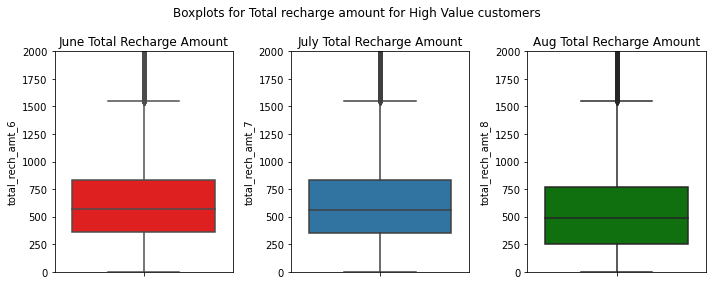

In [12]:
df = create_total_data_recharge_columns(eda)
df = filter_hvc(df)

fig, ax = plt.subplots(1,3, figsize=(10,4))
plt.suptitle("Boxplots for Total recharge amount for High Value customers");

sns.boxplot(y=df.total_rech_amt_6,ax=ax[0],color='r')
ax[0].set_title("June Total Recharge Amount")
ax[0].set_ylim([0, 2000])

sns.boxplot(y=df.total_rech_amt_7,ax=ax[1])
ax[1].set_title("July Total Recharge Amount")
ax[1].set_ylim([0, 2000])

sns.boxplot(y=df.total_rech_amt_8,ax=ax[2],color='g')
ax[2].set_title("Aug Total Recharge Amount")
ax[2].set_ylim([0, 2000])

plt.show()

Observation:
1. The dataset has been refined for targeting high value customers.
2. For the entire set, the median value for customers is 250 INR, but for high value customers is 500 INR.
3. High value customers are generally recharging the same amount.

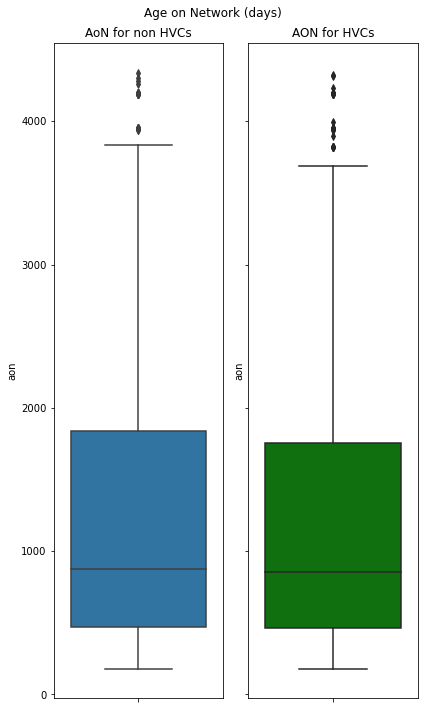

In [13]:
# Age on networks
df = create_total_data_recharge_columns(eda)
hvc = filter_hvc(df) ## High Value customer data

index_hvc = hvc.index.tolist()
non_hvc = df[~df.index.isin(index_hvc)] ##Non High value customer

fig, ax = plt.subplots(1,2, figsize=(6,10), sharey=True)

sns.boxplot(y=non_hvc.aon,ax=ax[0])
ax[0].set_title("AoN for non HVCs")

sns.boxplot(y=hvc.aon,ax=ax[1],color='g')
ax[1].set_title("AON for HVCs")

plt.suptitle("Age on Network (days)")
plt.show();

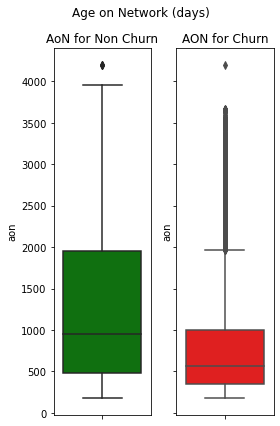

In [14]:
df_1 = df[df["churn_probability"]==1]

df_0 = df[df["churn_probability"]==0]
df_0 = df_0.sample(len(df_1),random_state=seed) # Take same number of rows as in churn dataset.

fig, ax = plt.subplots(1,2, figsize=(4,6), sharey=True)

sns.boxplot(y=df_0.aon,ax=ax[0],color='green')
ax[0].set_title("AoN for Non Churn")

sns.boxplot(y=df_1.aon,ax=ax[1],color='red')
ax[1].set_title("AON for Churn")

plt.suptitle("Age on Network (days)")
plt.show();

Observations:
1. The median Age on network for High value customers and Non High value customers are roughly the same.
2. The churn customers have a lower AON i.e. new customers are more likely to churn faster as they have not used their mobile numbers, thus can easily switch to a new service without consquences.

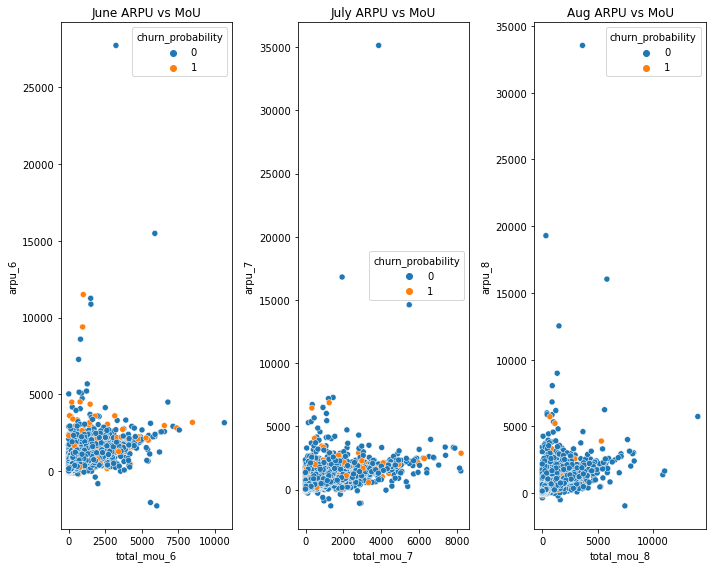

In [15]:
#Minutes of usaage
df = create_total_data_recharge_columns(eda)
hvc = filter_hvc(df) ## High Value customer data
index_hvc = hvc.index.tolist()

non_hvc = df[~df.index.isin(index_hvc)] ##Non High value customer

## Create the minutes of usage  columns:
df = create_mou(df)

fig, ax = plt.subplots(1,3, figsize=(10,8))

sns.scatterplot(y=df["arpu_6"],x=df["total_mou_6"],ax=ax[0],hue=df["churn_probability"])
ax[0].set_title("June ARPU vs MoU")

sns.scatterplot(y=df["arpu_7"],x=df["total_mou_7"],ax=ax[1],hue=df["churn_probability"])
ax[1].set_title("July ARPU vs MoU")

sns.scatterplot(y=df["arpu_8"],x=df["total_mou_8"],ax=ax[2],hue=df["churn_probability"])
ax[2].set_title("Aug ARPU vs MoU")
plt.show()

Observations:
- The good phase for the customers i.e months of June and July show that there is high usage of the network.
- The churn phase (8th Month - Aug) sees lower usage.

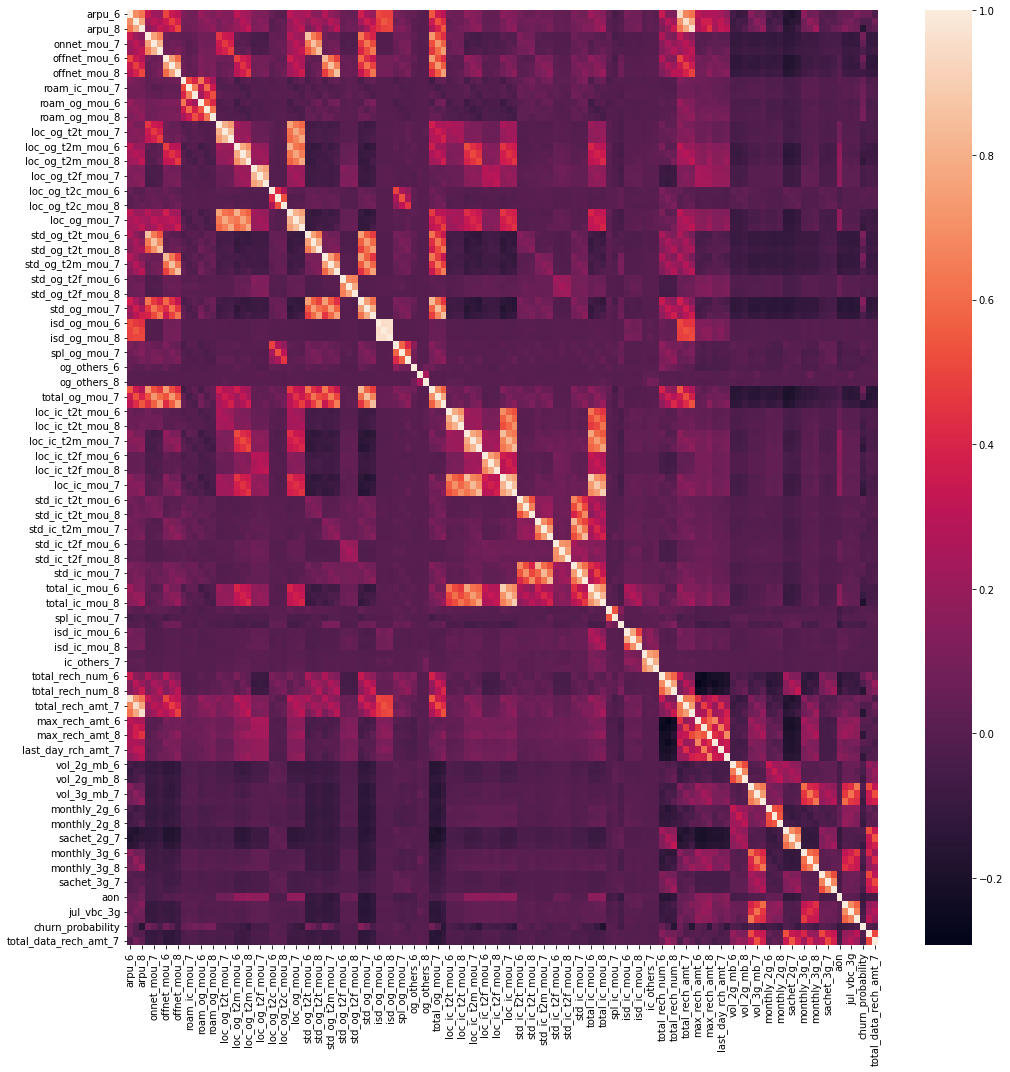

In [16]:
# Acquire the high value customers.
df = create_total_data_recharge_columns(eda)
df = filter_hvc(df)
df = missing_values(df)
df = redundant_columns(df)
corr = df.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr);

The heatmap is not exactly legible, inspite of removing a lot of columns. Thus, the below code will show the correlated features above a certain threshold defined by corr_threshold

In [17]:
corr = df.corr()
corr.loc[:, :] = np.tril(corr, -1)
corr = corr.stack()
high_corr_value = corr[(corr > corr_threshold) | (corr < -1*corr_threshold)]
high_corr_value.head(10) ## Only displaying top 10 for legibility.

arpu_8            arpu_7              0.781724
onnet_mou_7       onnet_mou_6         0.758087
onnet_mou_8       onnet_mou_7         0.809814
offnet_mou_7      offnet_mou_6        0.744686
offnet_mou_8      offnet_mou_7        0.768273
loc_og_t2t_mou_7  loc_og_t2t_mou_6    0.805506
loc_og_t2t_mou_8  loc_og_t2t_mou_6    0.736704
                  loc_og_t2t_mou_7    0.835972
loc_og_t2m_mou_7  loc_og_t2m_mou_6    0.787879
loc_og_t2m_mou_8  loc_og_t2m_mou_7    0.823089
dtype: float64

#### Data Preparation

In [18]:
# Create a copy of the master table:
temp = master.copy()

##### High-value customers

Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

1. Find out total amount spent by customers on data recharge.
2. Find averge for the good phase.
3. Calculate 70th percentile of recharge amount.

In [19]:
temp = create_total_data_recharge_columns(temp)
temp.shape

(69999, 170)

In [20]:
# Filtering high value customers
temp= filter_hvc(temp)
temp.shape

(20998, 170)

In [21]:
# removing missing values
temp = missing_values(temp)
temp.shape

(20998, 144)

In [22]:
# dropping correlated features
temp = drop_correlated_features(temp)
temp.shape

(20998, 105)

In [23]:
#creating new cols for mou
temp = create_mou(temp)
temp.shape

(20998, 102)

In [24]:
#Redundant Columns - Removing the date columns and single valued columns that are not necessary for our modelling purposes
temp = redundant_columns(temp)
temp = vbc_cols(temp)
temp.shape

(20998, 84)

In [25]:
# Handling outliers - The dataset has a lot of outliers, thus it is better to cap the important columns.
temp = cap_outlier(temp)
temp.shape

(20998, 84)

In [26]:
# Data Imputation - The rest of the numeric columns that might contain NaN values are replaced.
temp = impute_numeric(temp)
temp.shape

(20998, 84)

In [27]:
# Split the features into independent and target variable
y = temp["churn_probability"] 
X = temp.drop(["churn_probability"],axis=1)

In [28]:
# Standardize the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

### Handling Class Imbalance

A problem with imbalanced classification is that there are too few examples of the minority class for a model to effectively learn the decision boundary.

One way to solve this problem is to oversample the examples in the minority class. This can be achieved by simply duplicating examples from the minority class in the training dataset prior to fitting a model. This can balance the class distribution but does not provide any additional information to the model.

An improvement on duplicating examples from the minority class is to synthesize new examples from the minority class. This is a type of data augmentation for tabular data and can be very effective. The most widely used approach to synthesizing new examples is called the Synthetic Minority Oversampling TEchnique, or SMOTE for short.

In [29]:
y.value_counts(normalize=True)

0.0    0.917373
1.0    0.082627
Name: churn_probability, dtype: float64

In [30]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=seed)
X_res, y_res = sm.fit_resample(X_scaled,y)
y_res.value_counts()

0.0    19263
1.0    19263
Name: churn_probability, dtype: int64

In [31]:
# Dimensionality Reduction using PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=pca_comp)
X_pca = pca.fit_transform(X_res)

## Model Building

In [32]:
# Approach 1: XGBOOST
# Split the training dataset
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=test_set_size,random_state=seed)
cl = XGBClassifier()
cl.fit(X_train,y_train)
preds = cl.predict(X_test)

print(classification_report(y_test,preds))
# Hyperparameter Tuning for XGBoost 
# In the interest of training time, the below code has been commented
# XGBoost is a very computationally expensive algorithm, thus using default parameters (as shown in the above code)
params = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4],
              'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.4, 0.5, 0.6, 0.7],
              'max_depth': [5,6,7,8,10,20],
              'n_estimators': [50,80,100,150,250]
}

xgbc = XGBClassifier()    

#GridSearch instance of current iteration
clf = GridSearchCV(estimator=xgbc, param_grid=params, scoring='accuracy', return_train_score=True, verbose=1, cv=3)

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      3893
         1.0       0.97      0.97      0.97      3813

    accuracy                           0.97      7706
   macro avg       0.97      0.97      0.97      7706
weighted avg       0.97      0.97      0.97      7706



In [33]:
#Approach 2: Random Forest
# Split the training dataset:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=test_set_size,random_state=seed)
params = {
    'max_depth': [20, 30, 50,100],
    'min_samples_leaf': [5, 10, 20, 50],
    'min_samples_split': [2,3,5],    
    "criterion": ['gini', 'entropy']    
}

# random forest - the class weight is used to handle class imbalance - it adjusts the cost function
forest = RandomForestClassifier(n_jobs = -1,bootstrap=True,oob_score=True)
print(forest)
# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = seed)
# create gridsearch object
model = GridSearchCV(estimator=forest, cv=folds, param_grid=params, n_jobs=-1, verbose=1, scoring="accuracy")
model.fit(X_train,y_train)
## Should roughly take 15mins (on 4 cores)

RandomForestClassifier(n_jobs=-1, oob_score=True)
Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(n_jobs=-1, oob_score=True),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [20, 30, 50, 100],
                         'min_samples_leaf': [5, 10, 20, 50],
                         'min_samples_split': [2, 3, 5]},
             scoring='accuracy', verbose=1)

In [34]:
# Get the best estimator.
model.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=20, min_samples_leaf=5,
                       min_samples_split=3, n_jobs=-1, oob_score=True)

In [35]:
# Get the best parameters.
model.best_params_

{'criterion': 'entropy',
 'max_depth': 20,
 'min_samples_leaf': 5,
 'min_samples_split': 3}

In [36]:
#Matrix interpretation as per business context:
## Using our best parameters from GridSearch:
rf_best = RandomForestClassifier(n_estimators=100, max_depth=50, random_state=seed, min_samples_leaf=5, min_samples_split=3,criterion='entropy')
rf_best.fit(X_train,y_train)
y_test_pred  =  rf_best.predict(X_test)
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96      3893
         1.0       0.95      0.97      0.96      3813

    accuracy                           0.96      7706
   macro avg       0.96      0.96      0.96      7706
weighted avg       0.96      0.96      0.96      7706



In [37]:
cm  = confusion_matrix(y_test,y_test_pred)
TP = cm[1,1] # true positive 
TN = cm[0,0] # true negatives
FP = cm[0,1] # false positives
FN = cm[1,0] # false negatives

print(cm)

[[3712  181]
 [ 117 3696]]


In [38]:
# Let's see the sensitivity(recall) of our logistic regression model
sens = TP / float(TP+FN)
print(f"Recall: {sens}")

Recall: 0.969315499606609


#Approach 3 - logistic Regression
Experimentation via the Logistic Regression gave us very poor accuracy (~80%) on test set compared to Random Forest and XGBoost.
Thus, the modelling section has been removed. Instead, we will use Logistic Regression to derive the important features for making strategies to deal with churn. 
Random Forests and XGBoost, inspite of giving good results, doesn't provide interpretability like Logistic regression.

Derivation of Important features is shown below.

#### Testing on unseen data

In [39]:
test = pd.read_csv("test.csv")

In [40]:
# Create a copy of the master table:
churn = test.copy()

## Repeat the steps to remove the necessary columns:
churn = create_total_data_recharge_columns(churn)
churn = missing_values(churn)
churn = drop_correlated_features(churn)
churn = create_mou(churn)
churn = redundant_columns(churn)
churn = vbc_cols(churn)
churn = cap_outlier(churn)
churn = impute_numeric(churn)

print(churn.shape)

(30000, 83)


In [41]:
model_input = churn.to_numpy()
model_input_pca = pca.fit_transform(model_input)
model_preds = rf_best.predict(model_input)
model_preds

array([0., 0., 0., ..., 0., 0., 0.])

In [42]:
result = {
    "id": test["id"],
    "churn_probability":model_preds
}
df_output = pd.DataFrame(result)
df_output["churn_probability"].value_counts()

0.0    27562
1.0     2438
Name: churn_probability, dtype: int64

Notes:
- The final excel sheet ( <i>submission.csv</i> ) is likely to generate ~300 KB file
- This file was not consumed by the Kaggle Competition submission section inspite of correct structure. Reasons unknown
- Thus we had to create a new .csv file and copy paste the results from <i>submission.csv</i>.
- This results in ~250Kb file that was correctly consumed to generate the accuracy score.

In [43]:
## Create the output submission file:
df_output.to_csv("submission.csv", index=False)

In [44]:
# Important Feature Extraction using Logistic Regression

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, random_state=seed)
import statsmodels.api as sm

# Initial logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      churn_probability   No. Observations:                16798
Model:                            GLM   Df Residuals:                    16714
Model Family:                Binomial   Df Model:                           83
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2905.4
Date:                Wed, 15 Mar 2023   Deviance:                       5810.8
Time:                        18:10:27   Pearson chi2:                 2.34e+05
No. Iterations:                    12   Pseudo R-squ. (CS):             0.2051
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -1.4630      0.118    -12.373      0.000      -1.695      -1.231
arpu_6                    0.0002      0.000      1.298      0.194      -0.000       0.001
arpu_7                    0.0001      0.000      0.527      0.598      -0.000       0.001
arpu_8                   -0.0003      0.000     -1.246      0.213      -0.001       0.000
roam_ic_mou_6             0.0010      0.001      1.725      0.085      -0.000       0.002
roam_ic_mou_7         -2.911e-05      0.001     -0.055      0.956      -0.001       0.001
roam_ic_mou_8         -5.764e-05      0.000     -0.119      0.905      -0.001       0.001
roam_og_mou_6             0.0098      0.005      1.921      0.055      -0.000       0.020
roam_og_mou_7             0.0031      0.004      0.736      0.461      -0.005       0.011
roam_og_mou_8             0.0006      0.001      0.646      0.518      -0.001       0.002
loc_og_t2c_mou_6         -0.0110      0.007     -1.550      0.121      -0.025       0.003
loc_og_t2c_mou_7          0.0012      0.005      0.246      0.806      -0.008       0.011
loc_og_t2c_mou_8          0.0055      0.007      0.774      0.439      -0.008       0.019
loc_og_mou_6              0.0096      0.005      1.896      0.058      -0.000       0.020
loc_og_mou_7              0.0010      0.004      0.240      0.810      -0.007       0.009
loc_og_mou_8              0.0007      0.001      0.816      0.414      -0.001       0.003
std_og_t2f_mou_6         -0.0033      0.005     -0.604      0.546      -0.014       0.007
std_og_t2f_mou_7          0.0052      0.006      0.942      0.346      -0.006       0.016
std_og_t2f_mou_8         -0.0081      0.010     -0.854      0.393      -0.027       0.011
std_og_mou_6              0.0098      0.005      1.924      0.054      -0.000       0.020
std_og_mou_7              0.0019      0.004      0.448      0.654      -0.006       0.010
std_og_mou_8             -0.0005      0.001     -0.507      0.612      -0.002       0.001
isd_og_mou_6              0.0104      0.005      2.026      0.043       0.000       0.020
isd_og_mou_7              0.0036      0.004      0.806      0.420      -0.005       0.012
isd_og_mou_8             -0.0051      0.004     -1.229      0.219      -0.013       0.003
spl_og_mou_6              0.0120      0.005      2.243      0.025       0.002       0.023
spl_og_mou_7              0.0026      0.004      0.594      0.553      -0.006       0.011
spl_og_mou_8             -0.0050      0.004     -1.255      0.209      -0.013       0.003
og_others_6              -0.0377      0.019     -1.997      0.046      -0.075      -0.001
og_others_7               0.1646      0.164      1.002      0.316      -0.157       0.486
og_others_8              -0.9059      0.870     -1.042      0.298      -2.610       0.799
loc_ic_mou_6           

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

# Create LR object
logreg = LogisticRegression(solver='liblinear')

# Run RFE for 25 features
rfe = RFE(logreg, n_features_to_select=30)
rfe = rfe.fit(X_train, y_train)

rfe_col = X.columns[rfe.support_]
rfe_col

Index(['roam_og_mou_6', 'roam_og_mou_7', 'loc_og_t2c_mou_6',
       'std_og_t2f_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
       'spl_og_mou_7', 'spl_og_mou_8', 'loc_ic_mou_7', 'loc_ic_mou_8',
       'std_ic_t2t_mou_7', 'std_ic_t2t_mou_8', 'std_ic_t2f_mou_8',
       'std_ic_mou_8', 'isd_ic_mou_7', 'isd_ic_mou_8', 'ic_others_7',
       'total_rech_num_7', 'total_rech_num_8', 'last_day_rch_amt_8',
       'monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8', 'sachet_2g_6',
       'sachet_2g_8', 'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8',
       'sachet_3g_8'],
      dtype='object')

In [47]:
# Build model with RFE selected features
X_train_sm = sm.add_constant(X_train[rfe_col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      churn_probability   No. Observations:                16798
Model:                            GLM   Df Residuals:                    16767
Model Family:                Binomial   Df Model:                           30
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3290.7
Date:                Wed, 15 Mar 2023   Deviance:                       6581.5
Time:                        18:12:00   Pearson chi2:                 1.21e+06
No. Iterations:                     8   Pseudo R-squ. (CS):             0.1678
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.5322      0.070     -7.555      0.000      -0.670      -0.394
roam_og_mou_6          0.0006      0.000      2.316      0.021    9.11e-05       0.001
roam_og_mou_7          0.0017      0.000      5.551      0.000       0.001       0.002
loc_og_t2c_mou_6      -0.0057      0.005     -1.154      0.248      -0.015       0.004
std_og_t2f_mou_8      -0.0097      0.008     -1.156      0.248      -0.026       0.007
isd_og_mou_6           0.0040      0.002      2.422      0.015       0.001       0.007
isd_og_mou_7           0.0039      0.003      1.153      0.249      -0.003       0.011
isd_og_mou_8          -0.0072      0.003     -2.078      0.038      -0.014      -0.000
spl_og_mou_7           0.0033      0.002      1.599      0.110      -0.001       0.007
spl_og_mou_8          -0.0091      0.004     -2.539      0.011      -0.016      -0.002
loc_ic_mou_7           0.0023      0.000      9.155      0.000       0.002       0.003
loc_ic_mou_8          -0.0104      0.001    -18.415      0.000      -0.011      -0.009
std_ic_t2t_mou_7       0.0027      0.001      3.598      0.000       0.001       0.004
std_ic_t2t_mou_8      -0.0072      0.003     -2.758      0.006      -0.012      -0.002
std_ic_t2f_mou_8      -0.0064      0.008     -0.809      0.419      -0.022       0.009
std_ic_mou_8          -0.0018      0.001     -2.051      0.040      -0.003   -7.81e-05
isd_ic_mou_7           0.0018      0.001      3.060      0.002       0.001       0.003
isd_ic_mou_8          -0.0022      0.001     -2.170      0.030      -0.004      -0.000
ic_others_7           -0.0026      0.005     -0.529      0.597      -0.012       0.007
total_rech_num_7       0.0318      0.005      6.416      0.000       0.022       0.042
total_rech_num_8      -0.0960      0.008    -12.235      0.000      -0.111      -0.081
last_day_rch_amt_8    -0.0053      0.001    -10.180      0.000      -0.006      -0.004
monthly_2g_6          -0.0495      0.100     -0.494      0.621      -0.246       0.147
monthly_2g_7          -0.3846      0.114     -3.359      0.001      -0.609      -0.160
monthly_2g_8          -1.3636      0.194     -7.039      0.000      -1.743      -0.984
sachet_2g_6            0.0287      0.015      1.895      0.058      -0.001       0.058
sachet_2g_8           -0.3045      0.034     -8.878      0.000      -0.372      -0.237
monthly_3g_6           0.1928      0.072      2.680      0.007       0.052       0.334
monthly_3g_7          -0.1691      0.084     -2.002      0.045      -0.335      -0.004
monthly_3g_8          -0.7404      0.124     -5.974      0.000      -0.983      -0.497
sachet_3g_8           -0.2342      0.082     -2.840      0.005      -0.396      -0.073
======================================================================================
"""

In [48]:
# Predict on train data
y_train_pred = res.predict(X_train_sm).values.reshape(-1)
y_train_pred_final = pd.DataFrame({'Churn':y_train.values, 'Churn_Prob':y_train_pred})
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

,Churn,Churn_Prob,predicted
0,0.0,0.007432,0
1,0.0,0.014995,0
2,1.0,0.663194,1
3,0.0,0.018654,0
4,0.0,0.001397,0


In [49]:
from sklearn.metrics import accuracy_score, confusion_matrix
# Confusion matrix 
confusion = confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted )
print(confusion)

# The overall accuracy.
print(f'Accuracy : {accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted)}')

[[15253   139]
 [ 1135   271]]
Accuracy : 0.9241576378140255


In [50]:
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[rfe_col].columns
vif['VIF'] = [variance_inflation_factor(X_train[rfe_col].values, i) for i in range(X_train[rfe_col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
5,isd_og_mou_7,7.21
6,isd_og_mou_8,6.73
19,total_rech_num_8,6.18
18,total_rech_num_7,5.95
10,loc_ic_mou_8,5.26
9,loc_ic_mou_7,5.22
4,isd_og_mou_6,4.33
12,std_ic_t2t_mou_8,2.64
14,std_ic_mou_8,2.35
27,monthly_3g_7,2.30


In [51]:
rfe_col = rfe_col.drop('total_rech_num_7', 1) # DRop the top feature and recheck VIF values.

# Build new model
X_train_sm = sm.add_constant(X_train[rfe_col])
logm3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      churn_probability   No. Observations:                16798
Model:                            GLM   Df Residuals:                    16768
Model Family:                Binomial   Df Model:                           29
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3311.8
Date:                Wed, 15 Mar 2023   Deviance:                       6623.7
Time:                        18:12:01   Pearson chi2:                 1.68e+06
No. Iterations:                     8   Pseudo R-squ. (CS):             0.1657
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.3386      0.064     -5.329      0.000      -0.463      -0.214
roam_og_mou_6          0.0005      0.000      2.111      0.035    3.88e-05       0.001
roam_og_mou_7          0.0018      0.000      5.734      0.000       0.001       0.002
loc_og_t2c_mou_6      -0.0050      0.005     -1.085      0.278      -0.014       0.004
std_og_t2f_mou_8      -0.0116      0.009     -1.330      0.184      -0.029       0.006
isd_og_mou_6           0.0038      0.002      2.246      0.025       0.000       0.007
isd_og_mou_7           0.0043      0.003      1.268      0.205      -0.002       0.011
isd_og_mou_8          -0.0075      0.003     -2.154      0.031      -0.014      -0.001
spl_og_mou_7           0.0054      0.001      3.652      0.000       0.003       0.008
spl_og_mou_8          -0.0106      0.003     -3.115      0.002      -0.017      -0.004
loc_ic_mou_7           0.0025      0.000     10.358      0.000       0.002       0.003
loc_ic_mou_8          -0.0109      0.001    -19.302      0.000      -0.012      -0.010
std_ic_t2t_mou_7       0.0030      0.001      4.057      0.000       0.002       0.004
std_ic_t2t_mou_8      -0.0073      0.003     -2.775      0.006      -0.012      -0.002
std_ic_t2f_mou_8      -0.0061      0.008     -0.778      0.437      -0.021       0.009
std_ic_mou_8          -0.0018      0.001     -2.090      0.037      -0.004      -0.000
isd_ic_mou_7           0.0018      0.001      3.021      0.003       0.001       0.003
isd_ic_mou_8          -0.0022      0.001     -2.200      0.028      -0.004      -0.000
ic_others_7           -0.0020      0.005     -0.422      0.673      -0.011       0.007
total_rech_num_8      -0.0692      0.006    -10.681      0.000      -0.082      -0.056
last_day_rch_amt_8    -0.0056      0.001    -10.899      0.000      -0.007      -0.005
monthly_2g_6          -0.1080      0.100     -1.076      0.282      -0.305       0.089
monthly_2g_7          -0.3835      0.114     -3.357      0.001      -0.607      -0.160
monthly_2g_8          -1.3950      0.194     -7.192      0.000      -1.775      -1.015
sachet_2g_6            0.0315      0.015      2.086      0.037       0.002       0.061
sachet_2g_8           -0.3184      0.034     -9.316      0.000      -0.385      -0.251
monthly_3g_6           0.1561      0.072      2.154      0.031       0.014       0.298
monthly_3g_7          -0.1577      0.085     -1.860      0.063      -0.324       0.008
monthly_3g_8          -0.7817      0.124     -6.286      0.000      -1.025      -0.538
sachet_3g_8           -0.2446      0.083     -2.961      0.003      -0.407      -0.083
======================================================================================
"""

In [52]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[rfe_col].columns
vif['VIF'] = [variance_inflation_factor(X_train[rfe_col].values, i) for i in range(X_train[rfe_col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
5,isd_og_mou_7,7.18
6,isd_og_mou_8,6.70
10,loc_ic_mou_8,5.19
9,loc_ic_mou_7,5.05
4,isd_og_mou_6,4.33
12,std_ic_t2t_mou_8,2.64
14,std_ic_mou_8,2.35
26,monthly_3g_7,2.28
27,monthly_3g_8,2.18
24,sachet_2g_8,2.09


In [53]:
rfe_col = rfe_col.drop('isd_og_mou_7', 1) # DRop the top feature and recheck VIF values.

# Build new model
X_train_sm = sm.add_constant(X_train[rfe_col])
logm3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      churn_probability   No. Observations:                16798
Model:                            GLM   Df Residuals:                    16769
Model Family:                Binomial   Df Model:                           28
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3312.8
Date:                Wed, 15 Mar 2023   Deviance:                       6625.7
Time:                        18:12:02   Pearson chi2:                 1.70e+06
No. Iterations:                     8   Pseudo R-squ. (CS):             0.1656
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.3355      0.063     -5.287      0.000      -0.460      -0.211
roam_og_mou_6          0.0005      0.000      2.111      0.035    3.87e-05       0.001
roam_og_mou_7          0.0018      0.000      5.725      0.000       0.001       0.002
loc_og_t2c_mou_6      -0.0051      0.005     -1.097      0.273      -0.014       0.004
std_og_t2f_mou_8      -0.0118      0.009     -1.343      0.179      -0.029       0.005
isd_og_mou_6           0.0047      0.002      2.910      0.004       0.002       0.008
isd_og_mou_8          -0.0037      0.002     -2.355      0.019      -0.007      -0.001
spl_og_mou_7           0.0054      0.001      3.684      0.000       0.003       0.008
spl_og_mou_8          -0.0107      0.003     -3.132      0.002      -0.017      -0.004
loc_ic_mou_7           0.0025      0.000     10.404      0.000       0.002       0.003
loc_ic_mou_8          -0.0109      0.001    -19.299      0.000      -0.012      -0.010
std_ic_t2t_mou_7       0.0030      0.001      4.087      0.000       0.002       0.004
std_ic_t2t_mou_8      -0.0073      0.003     -2.771      0.006      -0.012      -0.002
std_ic_t2f_mou_8      -0.0060      0.008     -0.772      0.440      -0.021       0.009
std_ic_mou_8          -0.0018      0.001     -2.097      0.036      -0.004      -0.000
isd_ic_mou_7           0.0017      0.001      3.183      0.001       0.001       0.003
isd_ic_mou_8          -0.0020      0.001     -2.188      0.029      -0.004      -0.000
ic_others_7           -0.0023      0.005     -0.486      0.627      -0.012       0.007
total_rech_num_8      -0.0694      0.006    -10.721      0.000      -0.082      -0.057
last_day_rch_amt_8    -0.0057      0.001    -10.915      0.000      -0.007      -0.005
monthly_2g_6          -0.1098      0.100     -1.093      0.274      -0.307       0.087
monthly_2g_7          -0.3830      0.114     -3.355      0.001      -0.607      -0.159
monthly_2g_8          -1.3987      0.194     -7.204      0.000      -1.779      -1.018
sachet_2g_6            0.0312      0.015      2.064      0.039       0.002       0.061
sachet_2g_8           -0.3184      0.034     -9.313      0.000      -0.385      -0.251
monthly_3g_6           0.1579      0.072      2.182      0.029       0.016       0.300
monthly_3g_7          -0.1577      0.085     -1.860      0.063      -0.324       0.008
monthly_3g_8          -0.7853      0.124     -6.313      0.000      -1.029      -0.542
sachet_3g_8           -0.2450      0.083     -2.963      0.003      -0.407      -0.083
======================================================================================
"""

In [54]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[rfe_col].columns
vif['VIF'] = [variance_inflation_factor(X_train[rfe_col].values, i) for i in range(X_train[rfe_col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
9,loc_ic_mou_8,5.19
8,loc_ic_mou_7,5.05
5,isd_og_mou_8,3.66
4,isd_og_mou_6,3.63
11,std_ic_t2t_mou_8,2.62
13,std_ic_mou_8,2.35
25,monthly_3g_7,2.28
26,monthly_3g_8,2.18
23,sachet_2g_8,2.09
17,total_rech_num_8,1.99


In [55]:
rfe_col = rfe_col.drop('loc_ic_mou_8', 1) # DRop the top feature and recheck VIF values.

# Build new model
X_train_sm = sm.add_constant(X_train[rfe_col])
logm3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      churn_probability   No. Observations:                16798
Model:                            GLM   Df Residuals:                    16770
Model Family:                Binomial   Df Model:                           27
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3622.7
Date:                Wed, 15 Mar 2023   Deviance:                       7245.4
Time:                        18:12:03   Pearson chi2:                 1.52e+07
No. Iterations:                     8   Pseudo R-squ. (CS):             0.1342
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.3122      0.064     -4.896      0.000      -0.437      -0.187
roam_og_mou_6          0.0004      0.000      1.463      0.144      -0.000       0.001
roam_og_mou_7          0.0022      0.000      7.492      0.000       0.002       0.003
loc_og_t2c_mou_6      -0.0060      0.005     -1.129      0.259      -0.016       0.004
std_og_t2f_mou_8      -0.0221      0.011     -2.076      0.038      -0.043      -0.001
isd_og_mou_6           0.0057      0.002      3.385      0.001       0.002       0.009
isd_og_mou_8          -0.0044      0.002     -2.702      0.007      -0.008      -0.001
spl_og_mou_7           0.0093      0.002      5.658      0.000       0.006       0.013
spl_og_mou_8          -0.0176      0.004     -4.638      0.000      -0.025      -0.010
loc_ic_mou_7          -0.0013      0.000     -7.283      0.000      -0.002      -0.001
std_ic_t2t_mou_7       0.0043      0.001      5.867      0.000       0.003       0.006
std_ic_t2t_mou_8      -0.0103      0.003     -3.262      0.001      -0.016      -0.004
std_ic_t2f_mou_8      -0.0324      0.012     -2.805      0.005      -0.055      -0.010
std_ic_mou_8          -0.0044      0.001     -3.601      0.000      -0.007      -0.002
isd_ic_mou_7           0.0019      0.000      4.246      0.000       0.001       0.003
isd_ic_mou_8          -0.0029      0.001     -2.877      0.004      -0.005      -0.001
ic_others_7           -0.0013      0.004     -0.352      0.725      -0.009       0.006
total_rech_num_8      -0.1030      0.007    -15.189      0.000      -0.116      -0.090
last_day_rch_amt_8    -0.0084      0.001    -15.803      0.000      -0.009      -0.007
monthly_2g_6          -0.1186      0.098     -1.214      0.225      -0.310       0.073
monthly_2g_7          -0.4482      0.112     -4.015      0.000      -0.667      -0.229
monthly_2g_8          -1.5409      0.191     -8.059      0.000      -1.916      -1.166
sachet_2g_6            0.0387      0.015      2.610      0.009       0.010       0.068
sachet_2g_8           -0.3455      0.035     -9.833      0.000      -0.414      -0.277
monthly_3g_6           0.1882      0.071      2.648      0.008       0.049       0.328
monthly_3g_7          -0.2043      0.084     -2.427      0.015      -0.369      -0.039
monthly_3g_8          -0.8623      0.124     -6.930      0.000      -1.106      -0.618
sachet_3g_8           -0.2722      0.086     -3.152      0.002      -0.441      -0.103
======================================================================================
"""

In [56]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[rfe_col].columns
vif['VIF'] = [variance_inflation_factor(X_train[rfe_col].values, i) for i in range(X_train[rfe_col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
5,isd_og_mou_8,3.66
4,isd_og_mou_6,3.63
10,std_ic_t2t_mou_8,2.62
12,std_ic_mou_8,2.35
24,monthly_3g_7,2.28
25,monthly_3g_8,2.18
22,sachet_2g_8,2.09
16,total_rech_num_8,1.96
13,isd_ic_mou_7,1.95
23,monthly_3g_6,1.91


In [57]:
X_test = X_test[rfe_col]
X_test_sm = sm.add_constant(X_test)

# Predict on test data

y_test_pred = res.predict(X_test_sm)
y_test_pred_final = pd.DataFrame({'Churn':y_test.values, 'Churn_Prob':y_test_pred})
y_test_pred_final['predicted'] = y_test_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_test_pred_final.head()

,Churn,Churn_Prob,predicted
7752,0.0,0.171485,0
49756,0.0,0.006874,0
46982,0.0,0.000105,0
67518,0.0,0.003225,0
7725,0.0,0.050372,0


In [58]:
# Confusion matrix 
confusion = confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted )
print(confusion)

# The overall accuracy.
print(f'Accuracy : {accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted)}')

[[15253   139]
 [ 1135   271]]
Accuracy : 0.9241576378140255


In [59]:
# Inspite of drop in features, the accuracy is fairly well maintained. <br> Thus, we can go ahead with understanding the top 10 features that can be monitored to predict churn.

top_10 = abs(res.params).sort_values(ascending=False)[0:11]
top_10.pop('const')
print(top_10)

monthly_2g_8        1.540943
monthly_3g_8        0.862251
monthly_2g_7        0.448152
sachet_2g_8         0.345474
sachet_3g_8         0.272183
monthly_3g_7        0.204328
monthly_3g_6        0.188224
monthly_2g_6        0.118559
total_rech_num_8    0.103032
sachet_2g_6         0.038674
dtype: float64


#Interpretation of features
From the above list, it can be seen that the metrics of the 'action' phase are quite important. Monitoring the important metrics in the 8th month can help to prevent customer churn. The features to be kept in mind are:

1. Monthly Recharge of 2G and 3G Is the user recharging for large amount of data or not?
2. Sachet schemes for 2G and 3G : Is the user recharging for smaller amount. This could mean reduction in spend and thus churn.
3. Total amount of recharge : What is the amount of recharge done for the action phase? 
4. Data Recharge Amount of data recharge in the good phase of customer

Although, the below metrics do not show up in the list, domain expertise would show that the following metrics are quite important as well: 

1. ARPU : Tracking Average revenue per user for good and churn phase is important.
2. MOU : Minutes of usage for good and churn phase - lower MoU could mean an indication to churn.
3. AoN  : As seen during EDA, newer customers are more likely to churn. This is likely because they have not extensively used their number and thus can easily switch to a different network.